# **Machine Learning Reconstruction of Surface Ocean pCO₂**
Spring 2025, EESC4243/STAT4243/5243 “Climate Prediction Challenges with Machine Learning”, Columbia University

## Introduction 
The ocean plays a crucial role in the global carbon cycle by absorbing atmospheric CO₂, having absorbed 38% of all anthropogenic fossil fuel emissions over the industrial era. 

Accurate estimation of air–sea CO₂ flux is critical for understanding the current and future global carbon budget, yet remains challenging due to the sparse and unevenly distributed nature of surface ocean pCO₂ observations. The **Surface Ocean CO₂ Atlas (SOCAT)** database (https://socat.info/) provides the most extensive dataset available, but its coverage is limited to only about 2% of all boxes of 1 degree X 1 degree (= 100km X 100km at the equator) over the last several decades. Data are particularly limited in high-latitude regions and during winter months.

To fill in the gaps in these data, statistical and machine learning (ML) techniques have been widely used to reconstruct global pCO₂ fields by interpolating between observations using environmental predictors such as sea surface temperature (SST), sea surface salinity (SSS), mixed layer depth (MLD), chlorophyll-a (Chl-a), and atmospheric CO₂ (xCO₂).

How good are these methods? Since the real full-coverage pCO2 of the ocean is unknown, we need another approach to assess the skill of ML-based reconstructions. Our answer is the **Large Ensemble Testbed (LET)**, which provides full-coverage pCO₂ output from Earth System Models, as well as associated driver varibles also from the ESM. In the context of this testbed, we can sample the pCO2 in the same pattern as real-world SOCAT and then reconstruct. Since the full-field pCO2 field is known ("Model Truth"), we can directly evaluate of ML reconstruction performance. With this approach, it has been shown that ML methods can capture seasonal variability well, they often overestimate decadal variability, particularly in regions with limited data coverage (Gloege et al. 2021).

This study builds upon previous work by incorporating a **pCO₂-Residual** approach to improve ML-based pCO₂ reconstructions. The **pCO₂-Residual** method removes the temperature-driven component from pCO₂ before applying ML, thereby reducing the dominance of temperature in predictions and enhancing the ability of the model to capture non-temperature-driven variability. 


We reproduce a portion of the analysis carried out by  
**Gloege et al. (2021)** *"Quantifying Errors in Observationally Based Estimates of Ocean Carbon Sink Variability."* **Global Biogeochemical Cycles** 34: e2020GB006788.  
([DOI: 10.1029/2020GB006788](https://doi.org/10.1029/2020GB006788))  

using the method of  
**Bennington et al. (2022)** *"Explicit Physical Knowledge in Machine Learning for Ocean Carbon Flux Reconstruction: The pCO2-Residual Method"*. **Journal of Advances in Modeling Earth Systems**, 14(10). ([DOI: 10.1029/2021ms002960](https://doi.org/10.1029/2021ms002960))

Our study:
1. Implements an **XGBoost-based pCO₂-Residual reconstruction**  (Bennington et al. 2022).
2. Implements a **Feed Forward Neural Network**
3. Evaluates reconstruction performance using a Large Ensemble Testbed, with **bias and correlation metrics** as in Gloege et al (2021).


### Running Notes
1. Users need to enter their GitHub/LEAP-Pangeo username at the end of Section 2.
2. Several time-consuming steps have outputs saved to files, so they only need to be run initially or if changes are made:  
    - Section 4.3: ML Training (~1 minute/ESM member)  
    - Section 4.4: Reconstruction/Inference (~1 minute/ESM member)  
    - Section 4.4.1: Summation of pCO2-Residual and pCO2-T to recover pCO2 (~15 seconds/ESM member)


    With a **128GB CPU**, actual runtimes may vary based on system load and selected members, but this serves as a general guideline.

<div class="alert alert-block alert-info">
<b>your_username:</b> The username of the person running the code. 
<p><b>owner_username:</b> The username of the notebook owner.</p>
</div>

<div class="alert alert-warning">
<b>runthiscell:</b>(Default = 1) Disable a cell by setting <b>runthiscell=0</b>. Reviewers should set <b>runthiscell=-1</b> to save time and space. 
</div>

In [1]:
your_username = 'JuanPalaciosGodoy'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = 'JuanPalaciosGodoy'  # Reviewer should not change this name

## **2.1 Input (Features) Sources**
The **input features** for the machine learning model are derived from **pre-processed Earth System Model (ESM) outputs or inputs**

### **Feature and Target Variables for the ML Model**
The features used for training the **pCO₂-Residual machine learning model** are listed below:


| **Feature** | **Description** | **ESM Input or Output?** | 
|------------|----------------|----------------|
| **SST (Sea Surface Temperature)** | Simulated ocean surface temperature | **ESM Output** |  
| **SST_anom** | SST anomaly from climatology | **ESM Output** |  
| **SSS (Sea Surface Salinity)** | Simulated surface ocean salinity | **ESM Output** |  
| **SSS_anom** | SSS anomaly from climatology | **ESM Output** |  
| **MLD_clim_log** | Log-transformed climatological mixed layer depth | **ESM Output** |  
| **Chl-a (Chlorophyll concentration)** | Proxy for biological activity (log-transformed) | **ESM Output** |  
| **Chl-a_anom** | Anomaly of Chl-a | **ESM Output** |  
| **xCO₂ (Atmospheric CO₂ concentration)** | Atmospheric CO₂ mole fraction | **ESM Input, from data** |  
| **A, B, C** | Space on the globe | **See Bennington et al. 2022, Table 1** |  
| **T0, T1** | Time | **See Bennington et al. 2022, Table 1** |  


The **target variable** for reconstruction is:
- **pCO₂-Residual**: This deviation from the temperature-driven component of pCO₂, reducing SST's dominance in ML reconstructions and improving model performance in data-sparse regions (detailed below).
- **pCO₂-Residual-trend**: This is the trend component of pCO₂-Residual
- **pCO₂-Residual-seasonal**: This is the seasonal component of pCO₂-Residual
- **pCO₂-Residual-deseasonal**: This is the de-seasonal component of pCO₂-Residual

### **Key Considerations:**
- **pCO₂-Residual**: By removing the temperature-driven component from pCO₂, we enhance the ability of machine learning models to capture **non-temperature-driven variability**, particularly in poorly observed regions.
- **pCO₂-Residual** = pCO₂-Residual-trend + pCO₂-Residual-seasonal + pCO₂-Residual-deseasonal
- **Data Subsampling Based on SOCAT**: The use of a **SOCAT-derived mask** ensures that the ML model is trained and evaluated using a realistic observational distribution, mitigating potential biases from uneven data coverage.

### **Final Input Structure**:
- **Feature Matrix**: `(N, 12)`, where `N` represents the number of samples, and 12 predictor variables are used.
- **Target Variable**: `pCO₂-Residual`, which the model aims to reconstruct.


# 0.1. Input Parameters

In [2]:
# features for ML:
features_sel = ['sst','sst_anom','sss','sss_anom','mld_clim_log','chl_log','chl_log_anom','xco2','A', 'B', 'C', 'T0', 'T1']

# the target variable we reconstruct:
target_sel = ['pco2_residual_deseasonal'] #pco2_residual: this represents pCO2 - pCO2-T (calculated in notebook 00)

In [3]:
# Define date range
__MODEL_TYPE__ = "nn" # "xgb" or "nn"
__GRID_SEARCH_APPROACH__ = 'nmse'
__DATE_RANGE_START__ = '2004-01-01T00:00:00.000000000'
__DATE_RANGE_END__ = '2023-12-31T00:00:00.000000000'

# 0. Setup Workspace and Import Packages
We use %%capture to suppress output and keep the notebook clean. However, feel free to remove it if you want to check warnings or logs.


In [4]:
%%capture
!pip install tensorflow
!pip install keras
!pip install pytorch-ignite

In [5]:
%%capture
### standard imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import fsspec
import torch
### Python file with supporting functions ###
# standard imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
# Redirect all low-level stderr output
sys.stderr = open(os.devnull, 'w')

import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',100)
import csv
import cmocean as cm

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Python file with supporting functions
import lib.residual_utils as supporting_functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial
from lib.paths_utils import SavingPaths
from lib.model_utils import train_member_models, Models


E0000 00:00:1745618553.218150   14394 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745618553.226643   14394 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745618553.247650   14394 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745618553.247688   14394 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745618553.247691   14394 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745618553.247693   14394 computation_placer.cc:177] computation placer already registered. Please check linka

In [6]:
### Setting the date range to unify the date type ###

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=__DATE_RANGE_START__, 
                      end=__DATE_RANGE_END__,freq='MS')


init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')


### **Output Data Storage and Model Saving**

The output data generated by this notebook, including model predictions, performance metrics, and trained models, is saved in a cloud-based environment using a user-specific directory structure. This ensures that each user’s results are organized and accessible without interfering with others’ work.

The output data is organized into three main categories:  
1. **Machine Learning Models:** Trained models are saved for future use, ensuring that results can be replicated without re-training.  
2. **Reconstructions:** Predicted pCO₂ fields are stored for further analysis and visualization.  
3. **Performance Metrics:** CSV files containing test and unseen data performance metrics are saved for easy evaluation.

### **Data Sources and Paths**
The data is stored in a **cloud environment, LEAP-Pangeo**, ensuring efficient access and scalability for the machine learning workflow. Key datasets include:

- **Ensemble dir**:

  Contains the original data from pre-processed Earth System Model (ESM) outputs, available for 100+ ESM members. For computational efficiency, we rely on a selection of this dataset compiled by TA Xinyi Ke. The full ensemble data is available and could be explored, with due consideration of storage constraints. 
  
- **ML Input and Target Data**:

    Provides a dataframe-format dataset containing preprocessed ML inputs and ground truth from a selected subset of ensemble members. You may also generate your own dataset for a custom selection or range of members (see reference: Project3_Data.ipynb). Due to limited GCS storage, we recommend using the provided dataset for most projects.
  
- **SOCAT Data (Mask File)**:  

  Masking file based on real-world **SOCAT pCO₂ observations**. Here, these data are not used directly, but are input solely so that their sampling pattern in space and time can be applied to model pCO2 fields, thus mimicing real-world observational density.


In [7]:
# define loading and saving paths
saving_paths = SavingPaths(
    your_username=your_username,
    owner_username=owner_username,
    init_date=init_date,
    fin_date=fin_date,
    grid_search_approach=__GRID_SEARCH_APPROACH__,
    model=__MODEL_TYPE__
)

# 1. Surface ocean pCO2: A sparse data challenge

SOCAT data coverage is uneven, with some regions, particularly in the Southern Hemisphere and open ocean areas, having significantly fewer observations. Regions with denser observational coverage, such as the Northern Hemisphere, tend to have lower biases in CO2 flux reconstructions compared to sparsely sampled areas like the Southern Ocean.

# 2. Data Introduction and Storage

 **Compute the temperature-driven component** of pCO₂:

$$
\text{pCO}_{2,T} = \overline{\text{pCO}_2} \cdot \exp\left[ 0.0423 \cdot (T - \overline{T}) \right]
$$

- $ \overline{\text{pCO}_2} $: long-term mean of surface ocean pCO₂  
- $ T $: sea surface temperature at a given time/location  
- $ \overline{T} $: long-term mean sea surface temperature  
- $ 0.0423 $: empirically derived constant (from Takahashi et al., 1993)


 **Subtract to get the residual**:

$$
\text{pCO}_{2,\text{Residual}} = \text{pCO}_2 - \text{pCO}_{2,T}
$$

The residual is then decomposed into three separate components such that:

$$
\text{pCO}_{2,\text{Residual}} = \text{pCO}_{2,seasonal} + \text{pCO}_{2,deseasonal} + \text{pCO}_{2,trend}
$$

The seasonal and deseasonal components are then used as the **target variables** in ML training, helping disentangle the direct solubility-driven temperature effect from other biogeochemical processes.

In our workflow, this calculation was done during processing of the Earth System Model (ESM) dataset, not included in this notebook. The datasets under `ensemble_dir` include the variable `pCO2_T`. For this notebook, we will directly use the preprocessed ML input dataset, which includes `pco2_residual`.

Later in the notebook, we recover the total pCO2 by **adding the temperature component back** to the residual:

$$
\text{pCO}_2 = \text{pCO}_{2,\text{Residual}} + \text{pCO}_{2,T}
$$


In [8]:
### set up for getting files from leap bucket ###
fs = gcsfs.GCSFileSystem()


# 3.  Earth System Models and their Ensemble Members


In [9]:
mems_dict = dict()

# Get all paths
all_paths = fs.ls(saving_paths.inputs_path)

for ens_path in all_paths:             
    ens = ens_path.split('/')[-1]
    mems = fs.ls(ens_path)
    for mem in mems:        
        memo = mem.split('/')[-1]
        if ens not in mems_dict:
            mems_dict[ens] = [memo]
        elif ens in mems_dict:
            mems_dict[ens].append(memo)


In [10]:
## Here you can change which models and how many members you use
random.seed(42)  # Set seed for reproducibility

selected_ensembles = ['ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-LR']

selected_members_dict = {esm: mems_dict[esm] for esm in selected_ensembles}

selected_mems_dict = {}
num_members = 3  # Set the number of ensemble members from each ESM

for ens, members in selected_members_dict.items():
    if len(members) >= num_members:
        selected_mems_dict[ens] = random.sample(members, num_members)  # Select `num_members` random members
    else:
        selected_mems_dict[ens] = members  # If there are fewer members than `num_members`, select all

print(selected_mems_dict)

{'ACCESS-ESM1-5': ['member_r10i1p1f1', 'member_r5i1p1f1', 'member_r2i1p1f1'], 'CanESM5': ['member_r2i1p1f1', 'member_r1i1p2f1', 'member_r1i1p1f1'], 'MPI-ESM1-2-LR': ['member_r12i1p1f1', 'member_r11i1p1f1', 'member_r15i1p1f1']}


# 4. ML Reconstruction

## 4.1 Data Split

We split data to training data set and testing dataset based on date.

In [11]:
### train-validate-test split proportions ###

select_dates = []
test_dates = []

for i in range(0,len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i]) ### 80% train days set ###
    if i % 5 == 0:
        test_dates.append(dates[i]) ### 20% test days set ### 

### Then, the month numbers above are converted back to their respective datetime objects.

year_mon = []

for i in range(0,len(select_dates)):
    
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}")
    
test_year_mon = []

for i in range(0,len(test_dates)):
    
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")

## 4.2 Hyperparameters

In [12]:
__SEED__ = 10
torch.manual_seed(__SEED__)

if Models(__MODEL_TYPE__) == Models.NEURAL_NETWORK:
    params = {
        'input_nodes':13,
        'hidden_nodes':150,
        'output_nodes':1,
        'epochs':3000,
        'lr': 1e-03
    }
elif Models(__MODEL_TYPE__) == Models.XGBOOST:
    params = {
        'n_estimators': 500,  # Number of boosting rounds
        'max_depth': 6,  # Maximum depth of each tree to control model complexity
        'learning_rate': 0.05,  # Step size shrinkage to prevent overfitting
        'subsample': 0.8,  # Fraction of samples used for training each tree
        'colsample_bytree': 0.8,  # Fraction of features used per tree
        'gamma': 0.1,  # Minimum loss reduction required for further partitioning
        'min_child_weight': 5,  # Minimum sum of instance weight in a leaf node
        'reg_alpha': 0.1,  # L1 regularization to reduce model complexity
        'reg_lambda': 1.0,  # L2 regularization for preventing overfitting
        'objective': 'reg:squarederror',  # Loss function for regression tasks
        'n_jobs': 30,  # Number of parallel threads to use for training
        'eval_metric': 'rmse',
        'early_stopping_rounds': 50  # Stop training if performance doesn't improve for 50 rounds
    }
else:
    raise ValueError(f"model {__MODEL_TYPE__} not supported! Please choose a model in [`{Models.NEURAL_NETWORK.value}`, `{Models.XGBOOST.value}`]")

### Important Note: Run ML (4.3) and Reconstruction (4.4) Part Only Once

The **ML Reconstruction** step needs to be run **only once** for each ML model developed. This helps save computational resources and execution time.

The reconstruction data is saved under our **own username-specific workspace** in GCS. This means that even if you exit and re-enter JupyterHub, your data will remain available, eliminating the need for reprocessing.

### Before Running Again:
Before re-running the ML training steps, make sure a new experiment is actually necessary. Avoiding redundant computations helps optimize time and resource usage. It's also a good idea to monitor your storage regularly and clean up unnecessary files. If you're certain that no new experiment is needed, you can comment out the relevant code (set runthiscell = "0") to prevent accidental re-execution.

For reviewer, set runthiscell to -1.

## ML train/val/test data
The ML model was trained on **masked synthetic data** that mimics real-world observational sampling patterns (SOCAT). Specifically, for each ensemble member, we:

1. **Filtered valid samples** by selecting grid cells that have:
   - No missing values in input features or the target (`pCO₂-Residual`),
   - Physically realistic `pCO₂-Residual` values (between -250 and 250 μatm),
   - An ocean mask indicating valid ocean regions.

2. **Identified SOCAT-like samples** using a binary `socat_mask`.  
   - We defined the **training pool** as grid cells where **`socat_mask == 1`**, and the time falls within a list of pre-selected training months (`year_mon`).
   - Similarly, **testing data** was drawn from SOCAT-like samples falling into the `test_year_mon` time range.

3. **Performed a secondary train/val split** (within the training pool) using a stratified random seed matrix (`random_seeds`), where the seed location is tied to each ensemble member to ensure reproducibility and model diversity across members.

4. The **“unseen” data**, i.e., where **`socat_mask == 0`** but data is otherwise valid, was reserved for reconstruction evaluation in non-observed regions.

This ensures that:
- Training and testing sets do **not overlap in time** (`year_mon` vs. `test_year_mon`),
- And are drawn from the same spatial sampling mask, preserving the real-world SOCAT sampling pattern.



## 4.3 ML Training

To avoid re-run the ML training, set runthiscell = 0 

In [13]:
runthiscell = 1  # 0 will turn off, 1 will turn on, -1 will only run the first member. Reviewers should set this to -1.

if runthiscell:  
    
    seed_loc_dict = defaultdict(dict)
    for ens,mem_list in mems_dict.items():
        sub_dictt = dict()
        for no,mem in enumerate(mem_list):
            sub_dictt.update({mem:no})
        seed_loc_dict.update({ens:sub_dictt})

    if runthiscell == -1:
        print("Reviewing process: Running ML only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][0]   # Get the first member in that ensemble
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member
    else:
        run_selected_mems_dict = selected_mems_dict
    
    train_member_models(
        saving_paths=saving_paths,
        features=features_sel,
        target=target_sel,
        train_year_mon=year_mon,
        test_year_mon=test_year_mon,
        run_selected_mems_dict=run_selected_mems_dict,
        seed_loc_dict=seed_loc_dict,
        dates=dates,
        model_type=__MODEL_TYPE__,
        is_training=True,
        **params
    )
            

2025-04-25 22:02:37.453306
ACCESS-ESM1-5 member_r10i1p1f1


Training Progress: 100%|██████████| 3000/3000 [02:46<00:00, 18.00epoch/s, patience_count=40, train_loss=4.39, valid_loss=4.36] 


Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_ACCESS-ESM1-5_r10i1p1f1_mon_1x1_200401_202312.pth
Local model saving process complete.
test performance metrics: {'mse': 50.8695917749573, 'mae': 4.556679603883327, 'medae': 3.0376734917510273, 'max_error': 172.83922190844845, 'bias': -0.20942273426141297, 'r2': -0.12472123247739897, 'corr': 0.7961177825927734, 'cent_rmse': 7.132292182388303, 'stdev': 6.725295543670654, 'amp_ratio': 0.4295101224078716, 'stdev_ref': 11.20766621576029, 'range_ref': 349.98709041861696, 'iqr_ref': 9.363887500980194}
ACCESS-ESM1-5 member_r5i1p1f1


Training Progress: 100%|██████████| 3000/3000 [02:44<00:00, 18.19epoch/s, patience_count=16, train_loss=4.3, valid_loss=4.3]   


Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_ACCESS-ESM1-5_r5i1p1f1_mon_1x1_200401_202312.pth
Local model saving process complete.
test performance metrics: {'mse': 49.48525914073818, 'mae': 4.489405852018422, 'medae': 2.9246131401902744, 'max_error': 120.26437591975721, 'bias': -0.4325445462692382, 'r2': -0.44297487310926487, 'corr': 0.7683795690536499, 'cent_rmse': 7.034575974480493, 'stdev': 5.85616397857666, 'amp_ratio': 0.39056220563873356, 'stdev_ref': 10.437129344919768, 'range_ref': 229.3446609405737, 'iqr_ref': 9.092085491835636}
ACCESS-ESM1-5 member_r2i1p1f1


Training Progress: 100%|██████████| 3000/3000 [02:49<00:00, 17.70epoch/s, patience_count=14, train_loss=4.37, valid_loss=4.37] 


Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_ACCESS-ESM1-5_r2i1p1f1_mon_1x1_200401_202312.pth
Local model saving process complete.
test performance metrics: {'mse': 53.686031049319986, 'mae': 4.795366521438301, 'medae': 3.1365654844355717, 'max_error': 126.3292144065473, 'bias': 0.2706120946915762, 'r2': 0.19743441105749993, 'corr': 0.8390800952911377, 'cent_rmse': 7.327075204289907, 'stdev': 8.178903579711914, 'amp_ratio': 0.4286588231151789, 'stdev_ref': 12.677984397549604, 'range_ref': 299.34262405025964, 'iqr_ref': 9.716858196018013}
CanESM5 member_r2i1p1f1


Training Progress: 100%|██████████| 3000/3000 [02:50<00:00, 17.55epoch/s, patience_count=7, train_loss=4.11, valid_loss=4.11] 


Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_CanESM5_r2i1p1f1_mon_1x1_200401_202312.pth
Local model saving process complete.
test performance metrics: {'mse': 37.60717144442784, 'mae': 4.244549977053939, 'medae': 2.9680417884544132, 'max_error': 65.33137972634188, 'bias': -0.09285122810891412, 'r2': -0.30923703183655493, 'corr': 0.7700352668762207, 'cent_rmse': 6.132468625637464, 'stdev': 5.359580993652344, 'amp_ratio': 0.6368682475589451, 'stdev_ref': 9.216950127062535, 'range_ref': 175.21664876787116, 'iqr_ref': 8.468778619271207}
CanESM5 member_r1i1p2f1


Training Progress: 100%|██████████| 3000/3000 [02:48<00:00, 17.77epoch/s, patience_count=119, train_loss=4.27, valid_loss=4.28]


Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_CanESM5_r1i1p2f1_mon_1x1_200401_202312.pth
Local model saving process complete.
test performance metrics: {'mse': 42.12721493990308, 'mae': 4.352002652590679, 'medae': 2.996990582859114, 'max_error': 147.2037450553301, 'bias': 0.0143302324918652, 'r2': -0.20323313679179944, 'corr': 0.7688005566596985, 'cent_rmse': 6.49054812322527, 'stdev': 5.917129993438721, 'amp_ratio': 0.5123908509860265, 'stdev_ref': 9.822585532587933, 'range_ref': 306.3797992344884, 'iqr_ref': 9.199297998005951}
CanESM5 member_r1i1p1f1


Training Progress: 100%|██████████| 3000/3000 [02:51<00:00, 17.49epoch/s, patience_count=45, train_loss=4.3, valid_loss=4.32]  


Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_CanESM5_r1i1p1f1_mon_1x1_200401_202312.pth
Local model saving process complete.
test performance metrics: {'mse': 43.12508271254456, 'mae': 4.511626448803603, 'medae': 3.174693131277876, 'max_error': 174.33497873089996, 'bias': 0.12605564891350818, 'r2': -0.27370455826636375, 'corr': 0.7841789722442627, 'cent_rmse': 6.566969065904343, 'stdev': 5.818824291229248, 'amp_ratio': 0.4195936605805168, 'stdev_ref': 10.046827537117176, 'range_ref': 302.42216782521314, 'iqr_ref': 9.296911454568521}
MPI-ESM1-2-LR member_r12i1p1f1


Training Progress: 100%|██████████| 3000/3000 [02:50<00:00, 17.61epoch/s, patience_count=54, train_loss=6.3, valid_loss=6.32]  


Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_MPI-ESM1-2-LR_r12i1p1f1_mon_1x1_200401_202312.pth
Local model saving process complete.
test performance metrics: {'mse': 86.37864098586694, 'mae': 6.35734445018959, 'medae': 4.364456933235004, 'max_error': 125.97136073543618, 'bias': -0.5942633977169349, 'r2': 0.05878596991872276, 'corr': 0.823631763458252, 'cent_rmse': 9.29401102785374, 'stdev': 9.579959869384766, 'amp_ratio': 0.5269002592815415, 'stdev_ref': 15.407636970842848, 'range_ref': 289.02223141724295, 'iqr_ref': 13.693545072481536}
MPI-ESM1-2-LR member_r11i1p1f1


Training Progress: 100%|██████████| 3000/3000 [02:50<00:00, 17.62epoch/s, patience_count=31, train_loss=5.88, valid_loss=5.91] 


Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_MPI-ESM1-2-LR_r11i1p1f1_mon_1x1_200401_202312.pth
Local model saving process complete.
test performance metrics: {'mse': 84.8740843674595, 'mae': 6.143417679248535, 'medae': 4.008641208364999, 'max_error': 96.76075114298821, 'bias': -0.1847774613398521, 'r2': 0.04994676965145506, 'corr': 0.8102152347564697, 'cent_rmse': 9.212713192510636, 'stdev': 9.451881408691406, 'amp_ratio': 0.6355483498313261, 'stdev_ref': 15.016696459203715, 'range_ref': 276.23564988688753, 'iqr_ref': 12.250944244646178}
MPI-ESM1-2-LR member_r15i1p1f1


Training Progress: 100%|██████████| 3000/3000 [02:46<00:00, 18.06epoch/s, patience_count=72, train_loss=6.32, valid_loss=6.33] 


Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_MPI-ESM1-2-LR_r15i1p1f1_mon_1x1_200401_202312.pth
Local model saving process complete.
test performance metrics: {'mse': 97.9744484660462, 'mae': 6.684710013788349, 'medae': 4.505973718581492, 'max_error': 75.91137883344065, 'bias': -0.6328714274586329, 'r2': 0.0956834018560544, 'corr': 0.8284994959831238, 'cent_rmse': 9.898204305127582, 'stdev': 10.408803939819336, 'amp_ratio': 0.589507686827351, 'stdev_ref': 16.59870113441088, 'range_ref': 259.1814019139074, 'iqr_ref': 14.173332968984619}
end of all members 2025-04-25 22:34:49.732260


## 4.4 Reconstruction

### What Are We Reconstructing?

After training the model, we generate pCO₂ predictions not just for evaluation but also for reconstructing spatial fields across different sample categories:

1. **`unseen_sel`**: These are grid points that are valid (no missing values, within physical bounds) but **not observed** in the SOCAT dataset (i.e., `socat_mask == 0`). Predictions on these samples (`y_pred_unseen`) test the model’s ability to generalize beyond observed regions.

2. **`sel`**: These are SOCAT-like samples where `socat_mask == 1`. They include both training and test data (depending on the year/month). Predictions here (`y_pred_seen`) are used to assess performance where observations exist.


### Explanation of Reconstruction Output Variables

Each column added to the DataFrame (`df`) serves a specific purpose in evaluation and reconstruction:

| Variable | Description |
|----------|-------------|
| `pCO2_truth` | The actual pCO₂ residual values|
| `pCO2_recon_full` | The full reconstruction result (predicted values across both SOCAT and unseen regions). |
| `pCO2_recon_unseen` | Predicted values only for unseen regions (where `socat_mask == 0`). |


If you have not changed your ML, the reconstruction step (~1 minute/member) does not need to be re-run

In [14]:
runthiscell = 1  # 0 will turn off, 1 will turn on, -1 will only run the first member. Reviewers should set this to -1.

if runthiscell:

    if runthiscell == -1:
        print("Reviewing process: Running reconstrunction only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][0]   # Get the first member in that ensemble
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member
    else:
        run_selected_mems_dict = selected_mems_dict

    train_member_models(
        saving_paths=saving_paths,
        features=features_sel,
        target=target_sel,
        train_year_mon=year_mon,
        test_year_mon=test_year_mon,
        run_selected_mems_dict=run_selected_mems_dict,
        seed_loc_dict=seed_loc_dict,
        dates=dates,
        model_type=__MODEL_TYPE__,
        is_training=False,
        **params
    )

2025-04-25 22:34:49.798541
ACCESS-ESM1-5 member_r10i1p1f1
loading model...


/home/jovyan/climate-ml-project3-group2/Project3-ReconstructPCO2/lib/model_utils.py:731: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Len(x_seen): 223881
Len(x_unseen): 7859704
Starting reconstruction saving process
gs://leap-persistent/JuanPalaciosGodoy/JuanPalaciosGodoy/pco2_residual/nmse/post02_nn/reconstructions/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2residual_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr
Save complete
unseen performance metrics: {'mse': 59.83922855110065, 'mae': 4.612665820494003, 'medae': 3.034554021302192, 'max_error': 225.15150090052546, 'bias': -0.21269828175061087, 'r2': -0.32421269440177913, 'corr': 0.789251983165741, 'cent_rmse': 7.735581978823614, 'stdev': 6.72224235534668, 'amp_ratio': 0.5735638196715624, 'stdev_ref': 11.84421501372007, 'range_ref': 499.2289451041329, 'iqr_ref': 8.997386231002563}
ACCESS-ESM1-5 member_r5i1p1f1
loading model...


/home/jovyan/climate-ml-project3-group2/Project3-ReconstructPCO2/lib/model_utils.py:731: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Len(x_seen): 223881
Len(x_unseen): 7859796
Starting reconstruction saving process
gs://leap-persistent/JuanPalaciosGodoy/JuanPalaciosGodoy/pco2_residual/nmse/post02_nn/reconstructions/ACCESS-ESM1-5/member_r5i1p1f1/recon_pCO2residual_ACCESS-ESM1-5_member_r5i1p1f1_mon_1x1_200401_202312.zarr
Save complete
unseen performance metrics: {'mse': 51.95335247886841, 'mae': 4.56607321614963, 'medae': 3.084083494721197, 'max_error': 229.96982285661505, 'bias': -0.2803703151820644, 'r2': -0.5365454845010509, 'corr': 0.7496091723442078, 'cent_rmse': 7.207867401587547, 'stdev': 5.814791202545166, 'amp_ratio': 0.32800551734681166, 'stdev_ref': 10.446700699125646, 'range_ref': 483.5798284421219, 'iqr_ref': 8.842815576100632}
ACCESS-ESM1-5 member_r2i1p1f1
loading model...


/home/jovyan/climate-ml-project3-group2/Project3-ReconstructPCO2/lib/model_utils.py:731: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Len(x_seen): 223881
Len(x_unseen): 7859769
Starting reconstruction saving process
gs://leap-persistent/JuanPalaciosGodoy/JuanPalaciosGodoy/pco2_residual/nmse/post02_nn/reconstructions/ACCESS-ESM1-5/member_r2i1p1f1/recon_pCO2residual_ACCESS-ESM1-5_member_r2i1p1f1_mon_1x1_200401_202312.zarr
Save complete
unseen performance metrics: {'mse': 49.719478524114386, 'mae': 4.477521922081934, 'medae': 3.030529296257095, 'max_error': 229.83462437658721, 'bias': 0.2706942400867493, 'r2': -0.05604493940081445, 'corr': 0.7785130143165588, 'cent_rmse': 7.051204047828596, 'stdev': 6.86154842376709, 'amp_ratio': 0.31003487339156854, 'stdev_ref': 10.918563729772508, 'range_ref': 497.6869917838228, 'iqr_ref': 8.725793242757362}
CanESM5 member_r2i1p1f1
loading model...


/home/jovyan/climate-ml-project3-group2/Project3-ReconstructPCO2/lib/model_utils.py:731: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Len(x_seen): 226815
Len(x_unseen): 7868891
Starting reconstruction saving process
gs://leap-persistent/JuanPalaciosGodoy/JuanPalaciosGodoy/pco2_residual/nmse/post02_nn/reconstructions/CanESM5/member_r2i1p1f1/recon_pCO2residual_CanESM5_member_r2i1p1f1_mon_1x1_200401_202312.zarr
Save complete
unseen performance metrics: {'mse': 43.843681657300884, 'mae': 4.300498253184597, 'medae': 2.890812904672707, 'max_error': 261.10814750407394, 'bias': -0.2733653832277034, 'r2': -0.7625918869184201, 'corr': 0.7039949893951416, 'cent_rmse': 6.62145615837641, 'stdev': 4.9874396324157715, 'amp_ratio': 0.3378779562497422, 'stdev_ref': 9.098837931675906, 'range_ref': 430.53831549876577, 'iqr_ref': 7.872113100375085}
CanESM5 member_r1i1p2f1
loading model...


/home/jovyan/climate-ml-project3-group2/Project3-ReconstructPCO2/lib/model_utils.py:731: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Len(x_seen): 226778
Len(x_unseen): 7869016
Starting reconstruction saving process
gs://leap-persistent/JuanPalaciosGodoy/JuanPalaciosGodoy/pco2_residual/nmse/post02_nn/reconstructions/CanESM5/member_r1i1p2f1/recon_pCO2residual_CanESM5_member_r1i1p2f1_mon_1x1_200401_202312.zarr
Save complete
unseen performance metrics: {'mse': 44.812267251712285, 'mae': 4.304997727797224, 'medae': 2.8815147823311524, 'max_error': 242.01682327297863, 'bias': -0.12767939598904493, 'r2': -0.6709639107139853, 'corr': 0.6902948021888733, 'cent_rmse': 6.6941965351871975, 'stdev': 5.178630828857422, 'amp_ratio': 0.48640542371857987, 'stdev_ref': 9.120664994599526, 'range_ref': 443.8292428511999, 'iqr_ref': 8.049232780711584}
CanESM5 member_r1i1p1f1
loading model...


/home/jovyan/climate-ml-project3-group2/Project3-ReconstructPCO2/lib/model_utils.py:731: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Len(x_seen): 226815
Len(x_unseen): 7869125
Starting reconstruction saving process
gs://leap-persistent/JuanPalaciosGodoy/JuanPalaciosGodoy/pco2_residual/nmse/post02_nn/reconstructions/CanESM5/member_r1i1p1f1/recon_pCO2residual_CanESM5_member_r1i1p1f1_mon_1x1_200401_202312.zarr
Save complete
unseen performance metrics: {'mse': 47.51562187663813, 'mae': 4.479963401267613, 'medae': 3.0261932818991433, 'max_error': 242.5419718507575, 'bias': -0.1935573180383142, 'r2': -0.5714963730918086, 'corr': 0.72348952293396, 'cent_rmse': 6.893157612925888, 'stdev': 5.498719215393066, 'amp_ratio': 0.5676797669073034, 'stdev_ref': 9.728817127901658, 'range_ref': 444.3107029570223, 'iqr_ref': 8.477468472405441}
MPI-ESM1-2-LR member_r12i1p1f1
loading model...


/home/jovyan/climate-ml-project3-group2/Project3-ReconstructPCO2/lib/model_utils.py:731: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Len(x_seen): 224718
Len(x_unseen): 7850082
Starting reconstruction saving process
gs://leap-persistent/JuanPalaciosGodoy/JuanPalaciosGodoy/pco2_residual/nmse/post02_nn/reconstructions/MPI-ESM1-2-LR/member_r12i1p1f1/recon_pCO2residual_MPI-ESM1-2-LR_member_r12i1p1f1_mon_1x1_200401_202312.zarr
Save complete
unseen performance metrics: {'mse': 100.96588341370192, 'mae': 6.567469741080411, 'medae': 4.447512231938697, 'max_error': 199.91949123060238, 'bias': -0.5635427859859067, 'r2': 0.004448989890633359, 'corr': 0.8094270825386047, 'cent_rmse': 10.04817811415094, 'stdev': 10.070606231689453, 'amp_ratio': 0.5073202010657113, 'stdev_ref': 16.255546492358047, 'range_ref': 435.04233481512915, 'iqr_ref': 13.140538693848287}
MPI-ESM1-2-LR member_r11i1p1f1
loading model...


/home/jovyan/climate-ml-project3-group2/Project3-ReconstructPCO2/lib/model_utils.py:731: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Len(x_seen): 224718
Len(x_unseen): 7850081
Starting reconstruction saving process
gs://leap-persistent/JuanPalaciosGodoy/JuanPalaciosGodoy/pco2_residual/nmse/post02_nn/reconstructions/MPI-ESM1-2-LR/member_r11i1p1f1/recon_pCO2residual_MPI-ESM1-2-LR_member_r11i1p1f1_mon_1x1_200401_202312.zarr
Save complete
unseen performance metrics: {'mse': 85.41501062218339, 'mae': 6.077662128581858, 'medae': 4.10831123586666, 'max_error': 203.3736667539883, 'bias': -0.06782762760803757, 'r2': 0.1450345312509138, 'corr': 0.7985543012619019, 'cent_rmse': 9.242024162605473, 'stdev': 9.995231628417969, 'amp_ratio': 0.7751749738575869, 'stdev_ref': 14.996993294111206, 'range_ref': 444.9210490908067, 'iqr_ref': 11.541543115000739}
MPI-ESM1-2-LR member_r15i1p1f1
loading model...


/home/jovyan/climate-ml-project3-group2/Project3-ReconstructPCO2/lib/model_utils.py:731: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Len(x_seen): 224718
Len(x_unseen): 7850082
Starting reconstruction saving process
gs://leap-persistent/JuanPalaciosGodoy/JuanPalaciosGodoy/pco2_residual/nmse/post02_nn/reconstructions/MPI-ESM1-2-LR/member_r15i1p1f1/recon_pCO2residual_MPI-ESM1-2-LR_member_r15i1p1f1_mon_1x1_200401_202312.zarr
Save complete
unseen performance metrics: {'mse': 97.39218520265139, 'mae': 6.637207611334506, 'medae': 4.588367142057482, 'max_error': 196.72436940544827, 'bias': -0.583363054665012, 'r2': 0.0770361417687615, 'corr': 0.8112332820892334, 'cent_rmse': 9.868747904503964, 'stdev': 10.272348403930664, 'amp_ratio': 0.6317397606198608, 'stdev_ref': 16.141865673345567, 'range_ref': 450.55360947243645, 'iqr_ref': 13.322328354349153}
end of all members 2025-04-25 22:49:24.685971


### 4.4.1 Add pCO2-seasonal + pCO2-deseasonal + pCO2-Temperature back to reconstructed pCO2-Residual, thus recovering pCO2 

In [15]:
runthiscell = 1  # 0 will turn off, 1 will turn on

if runthiscell:
    if runthiscell == -1:
        supporting_functions.calc_recon_pco2_modified(saving_paths.ensemble_dir, saving_paths.recon_output_dir, saving_paths.recon_output_dir_alternate, selected_mems_dict, init_date, fin_date, owner_username)
    else:
        supporting_functions.calc_recon_pco2_modified(saving_paths.ensemble_dir, saving_paths.recon_output_dir, saving_paths.recon_output_dir_alternate, selected_mems_dict, init_date, fin_date)



Current ESM: ACCESS-ESM1-5
On member member_r10i1p1f1
pco2T path: gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
pCO2R XGBoost path:gs://leap-persistent/JuanPalaciosGodoy/JuanPalaciosGodoy/pco2_residual/nmse/post02_nn/reconstructions/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2residual_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr
pCO2R NeuralNetwork path:gs://leap-persistent/JuanPalaciosGodoy/JuanPalaciosGodoy/pco2_residual/nmse/post02_nn/reconstructions/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2residual_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr
save path: gs://leap-persistent/JuanPalaciosGodoy/JuanPalaciosGodoy/pco2_residual/nmse/post02_nn/reconstructions/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr
finished with member_r10i1p1f1
On member member_r5i1p1f1
pco2T path: gs://leap-persistent/abbysh/pco2_all_members_19

**For the owner who completed the experiment and reconstructed the data:**

1. Ensure that the reconstruction data you saved under the specified path is clean, accurate, and ready for sharing.
2. Only the data you wish to save and provide to reviewers should be kept.
3. Change the permissions to allow others to read the data, ensuring it's accessible to reviewers.


**Reviewers should not run this cell**.


In [16]:
from google.cloud import storage

if runthiscell != -1:
    client = storage.Client()
    bucket = client.bucket("leap-persistent")
    
    prefix = f"{owner_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/"
    blobs = bucket.list_blobs(prefix=prefix)
    
    seen_dirs = set()  # Track top-level directories (immediate subdirectories of `reconstructions`)

    for blob in blobs:
        # Extract the relative path after `reconstructions/`
        relative_path = blob.name[len(prefix):]
        top_level_dir = relative_path.split("/")[0]  # Get first component

        try:
            # Make the file public
            blob.make_public()
            
            # Only print if it's a new top-level directory
            if top_level_dir not in seen_dirs:
                seen_dirs.add(top_level_dir)
                print(f"Made public: {top_level_dir}")
        except Exception as e:
            print(f"Failed to make public: {blob.name}")
            print(e)


###  4.4.3  Visualize the reconstruction for 1 month

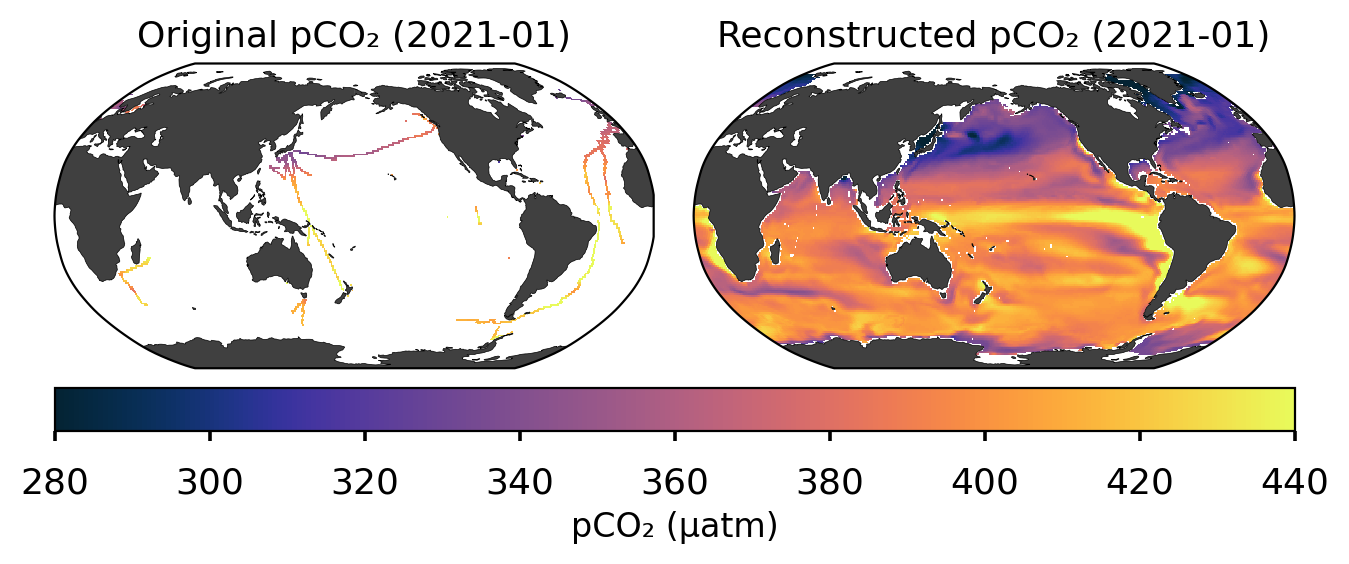

In [17]:
# Plot settings
plot_style = "seaborn-v0_8-talk"
cmap = cm.cm.thermal
cbar_title = 'pCO₂ (µatm)'
vrange = [280, 440]  # Colorbar range

# Select the first ensemble and member from the dictionary
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]

# Load original member data from ESM output
member_dir = f"{saving_paths.ensemble_dir}/{first_ens}/{first_mem}"
member_path = fs.glob(f"{member_dir}/*.zarr")[0]
# member_data = xr.open_mfdataset('gs://' + member_path, engine='zarr').sel(time=slice(str(dates[0]), str(dates[-1])))
member_data = xr.open_zarr('gs://' + member_path).sel(time=slice(str(dates[0]), str(dates[-1])))

# Load reconstructed pCO₂ data
recon_dir = f"{saving_paths.recon_output_dir}/{first_ens}/{first_mem}"    
recon_path = f"{recon_dir}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
full = xr.open_zarr(recon_path)["pCO2_recon_full"]

# Choose a specific month to visualize
chosen_time = '2021-01'
raw_data = member_data["spco2"].sel(time=chosen_time).squeeze()
recon_data = full.sel(time=chosen_time)[0, ...]

# Shift longitudes from [0, 360] to [-180, 180] for global plotting
raw_data = raw_data.roll(xlon=len(raw_data.xlon) // 2, roll_coords=True)
recon_data = recon_data.roll(xlon=len(recon_data.xlon) // 2, roll_coords=True)

# Load SOCAT mask and align longitude
socat_mask_data = xr.open_zarr(saving_paths.socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))
mask = socat_mask_data.sel(time=chosen_time)["socat_mask"].squeeze()
mask = mask.roll(xlon=len(mask.xlon) // 2, roll_coords=True)

# Mask original data where SOCAT mask == 0
masked_raw = np.ma.masked_array(raw_data, mask=(mask == 0))

# Start plotting side-by-side
with plt.style.context(plot_style):
#    fig = plt.figure(figsize=(10, 4), dpi=200)
    fig = plt.figure(figsize=(8, 3), dpi=200)
    worldmap = SpatialMap2(
        fig=fig, region='world',
        cbar_mode='single',  # Use one shared colorbar
        colorbar=True,
        cbar_location='bottom',
        nrows_ncols=[1, 2]
    )

    # Plot original (masked) and reconstructed data
    sub0 = worldmap.add_plot(
        lon=raw_data['xlon'], lat=raw_data['ylat'], data=masked_raw,
        vrange=vrange, cmap=cmap, ax=0
    )
    sub1 = worldmap.add_plot(
        lon=recon_data['xlon'], lat=recon_data['ylat'], data=recon_data,
        vrange=vrange, cmap=cmap, ax=1
    )

    worldmap.set_title("Original pCO₂ (2021-01)", ax=0, fontsize=13)
    worldmap.set_title("Reconstructed pCO₂ (2021-01)", ax=1, fontsize=13)

    colorbar = worldmap.add_colorbar(sub0, ax=0)
    worldmap.set_cbar_xlabel(colorbar, cbar_title, fontsize=12)

    plt.show()


The figure compares the original sparse pCO₂ selected from the first ESM member, consistent with real-world sampling, and the corresponding machine-learning-based reconstruction for January 2021.

# 5. Evaluation of the reconstruction against the original model output

## 5.1 Create a combined dataset with reconstruction and original 

We concatenate the outputs and ground truth from all members and ESMs into a single dataset, and then use this combined dataset to calculate bias, RMSE, and correlation.

In [18]:
datasets = []
for ensemble, members in selected_mems_dict.items():
    mems_dict = {ensemble: members}  
    ds = concat_datasets(mems_dict, recon_output_dir = saving_paths.recon_output_dir, init_date = init_date, fin_date=fin_date)
    datasets.append(ds)
concated_dataset = xr.concat(datasets, dim="ens")
evaluator = XarrayEvaluator(concated_dataset)

ds_eval = evaluator.compute_all_metrics()
print(ds_eval)

<xarray.Dataset> Size: 3GB
Dimensions:      (member: 8, time: 240, ylat: 180, xlon: 360, ens: 3)
Coordinates:
  * member       (member) object 64B 'member_r10i1p1f1' ... 'member_r5i1p1f1'
  * time         (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * ylat         (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * xlon         (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * ens          (ens) object 24B 'ACCESS-ESM1-5' 'CanESM5' 'MPI-ESM1-2-LR'
Data variables:
    bias         (ens, member, time, ylat, xlon) float64 3GB dask.array<chunksize=(1, 1, 100, 45, 90), meta=np.ndarray>
    rmse         (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>
    correlation  (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>


## 5.2 Descriptive Statistics

We can use ds_eval to easily compute descriptive statistics. In this example, we take the average across all time steps and ESMs:

In this example, we select the Northern Hemisphere (ylat from 0 to 90), flatten the spatial dimensions, drop missing values, and generate a summary using describe(). This gives us a statistical overview (mean, std, min, max, etc.) of the bias in the Northern Hemisphere.

You can change the selection for other regions and timeframes and ensemble members.

In [19]:
ds_eval_mean = (ds_eval['bias']*1).mean('ens').mean('time')
ds_eval_mean.sel(ylat=slice(0,90)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    95688.000000
mean        -0.637861
std          2.456799
min        -23.855583
25%         -1.767110
50%         -0.594143
75%          0.463612
max         27.291383
Name: bias, dtype: float64

## 5.3 Bias Visualizations
Based on this, we could visualize bias between reconstruction and model truth, averaged over the 100 ensemble members, each with a 
monthly resolution over the period init_date through fin_date. Red and blue shading indicates regions where the reconstruction is biased high or low, respectively. 

### 5.3.1 How well does the reconstruction capture the mean pCO2 field? 

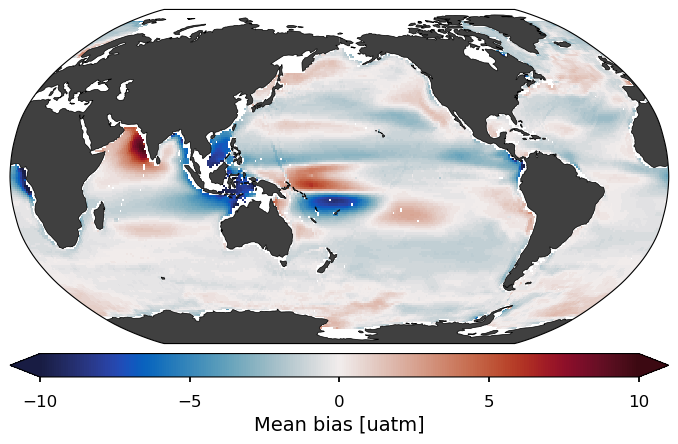

In [20]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()


### 5.3.2 Does ESM impact the estimate of the bias? 

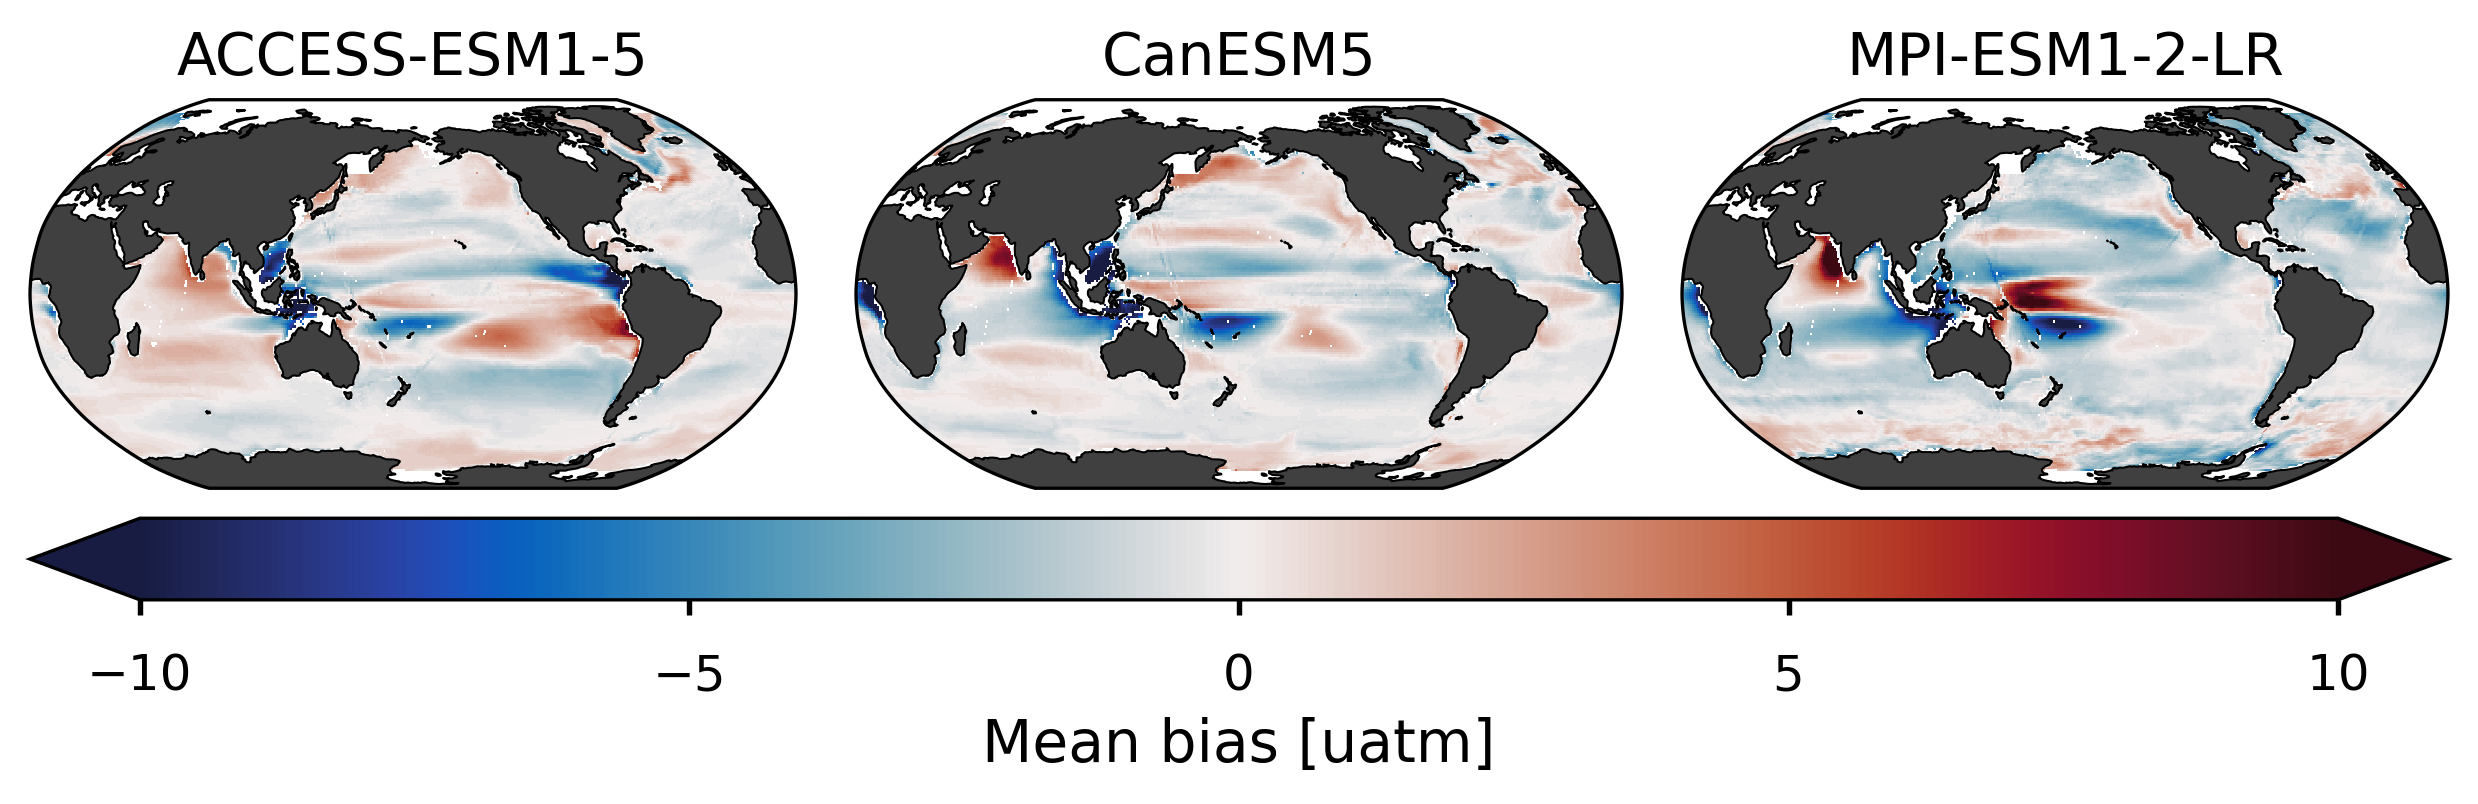

In [21]:
plot_style = "seaborn-v0_8-talk"
ensemble_means = ds_eval['bias'].mean(dim=['member', 'time'])

ensemble_names = list(ds_eval['ens'].values) 

vrange = [-10,10, 5]
cmap = cm.cm.balance

num_ensemble = len(ensemble_names)  
num_cols = 3  
num_rows = (num_ensemble + num_cols - 1) // num_cols 
with plt.style.context(plot_style):
    fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[num_rows, num_cols]) 
    for i in range(num_ensemble):
        data = ensemble_means.isel(ens=i)
        data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)  
        data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
        sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                                vrange=vrange[0:2], cmap=cmap, ax=i, linewidth_coast=0.5)
        worldmap.set_title(title=ensemble_names[i], ax=i, fontsize=14)

    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)

    worldmap.set_ticks(col, tmin=vrange[0], tmax=vrange[1], dt=vrange[2])

    col.ax.tick_params(labelsize=12)

    plt.show()


##  5.2 Reconstructed variability on seasonal, sub-decadal, and decadal timescales, compared to original model

Before computing spatial correlation metrics, we decompose both the reconstructed and reference pCO₂ fields into their long-term trend, seasonal cycle, and residual components using STL-like decomposition. We then evaluate their agreement by calculating gridwise correlation and standard deviation for each component across all ensemble members and ESMs.


In [22]:
# The calculation of these statistics takes about 1 min/member
ds_eval_corr = eval_spatial(selected_mems_dict, saving_paths.recon_output_dir, init_date, fin_date)

Starting computation for ESM: ACCESS-ESM1-5, Member: member_r10i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r5i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r2i1p1f1
Starting computation for ESM: CanESM5, Member: member_r2i1p1f1
Starting computation for ESM: CanESM5, Member: member_r1i1p2f1
Starting computation for ESM: CanESM5, Member: member_r1i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r12i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r11i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r15i1p1f1


Phasing of reconstruction variability on seasonal, sub-decadal, and decadal, compared to original model. Correlation between 
reconstruction and original model on (a) seasonal, (b) sub-decadal, and (c) decadal time scales. 

Here, the average correlations across all ensemble members are shown. 

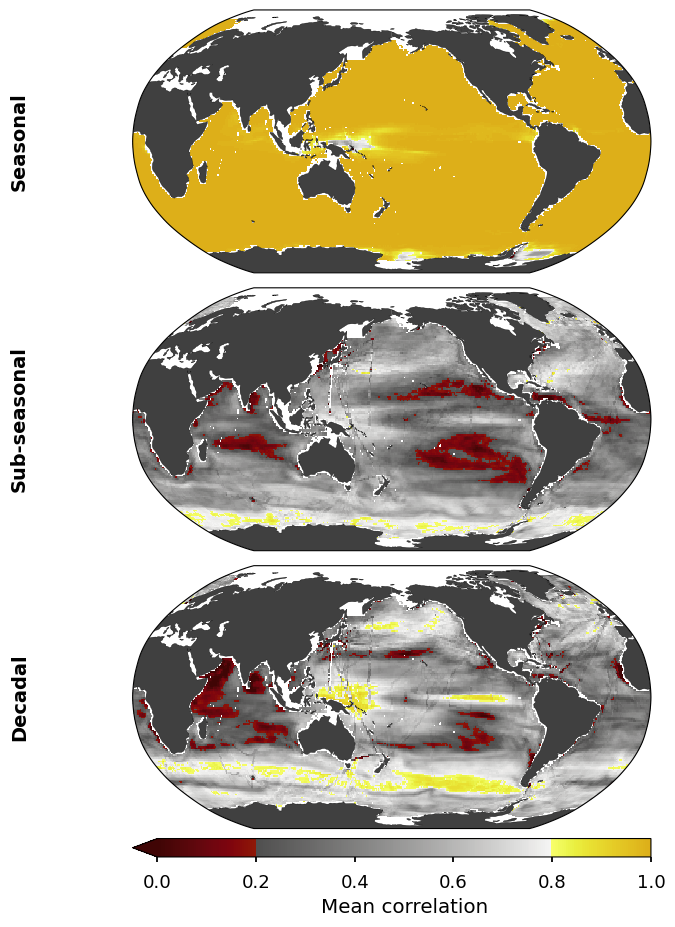

In [23]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    # Setup Figure
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world',
                   cbar_mode='edge',
                   axes_pad=0.15,
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[3,1])
    
    # Colorbar ranges
    vrange_col1 = [0, 1, 0.2]
    cmap_col1 = cm.cm.oxy
    
    ##-----------------------------------------------------
    ## Ensemble mean
    ##-----------------------------------------------------
    # Correlation - Annual-variation
    data = ds_eval_corr['corr_seasonal'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)

    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub0 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=0)
    
    
    # Correlation - sub-decadal
    data = ds_eval_corr['corr_residual'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub2 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=1)
    
    # Correlation - decadal
    data = ds_eval_corr['corr_dec'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub4 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=2)
    
    # add colorbar
    col1 = worldmap.add_colorbar(sub0, ax=0, extend='min')
    worldmap.set_cbar_xlabel(col1, f'Mean correlation')
    worldmap.set_ticks(col1, vrange_col1[0], vrange_col1[1], vrange_col1[2])

    worldmap.grid[0].text(-0.2, 0.5, "Seasonal", transform=worldmap.grid[0].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
    
    worldmap.grid[1].text(-0.2, 0.5, "Sub-seasonal", transform=worldmap.grid[1].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
    
    worldmap.grid[2].text(-0.2, 0.5, "Decadal", transform=worldmap.grid[2].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)

    
    plt.show()

The reconstructed pCO₂ has highest fidelity on seasonal timescales, but is less accurate for sub-seasonal and decadal timescale variability. 

### **Final Check for Redundant Files**  

#### **For Both Owners and Reviewers:**  
After execution is complete, review the project directory for any redundant files. Ensure that only necessary and relevant files are retained.  

#### **For Reviewers:**  
Once you have finished reviewing a project, you may delete files related to that project to free up storage space. However, be careful not to remove any data you still need.

As an **owner**, your reconstruction data is stored under:  

```
gs://leap-persistent/{owner_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/
```

If you are **reviewing someone else’s project**, their data and experiment results will be stored under your username in the following path:  

```
gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/
```

After completing the review, you can delete the files under `{owner_username}` in your directory to free up storage space. This ensures that only necessary data is retained while removing redundant files from past reviews.

In [24]:
if runthiscell == -1:   # Only reviewers should delete data under this path. Everyone should clear redundant data, but be cautious not to delete necessary files.
    client = storage.Client()
    bucket = client.bucket("leap-persistent")
    
    prefix = f"{your_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/"
    
    blobs = bucket.list_blobs(prefix=prefix)
    
    files_deleted = 0
    for blob in blobs:
        try:
            blob.delete()
            print(f"Deleted: {blob.name}")
            files_deleted += 1
        except Exception as e:
            print(f"Failed to delete: {blob.name}")
            print(e)
    
    if files_deleted > 0:
        print(f"Successfully deleted {files_deleted} files under {reviewing_owner}'s directory.")
    else:
        print(f"No files found for {reviewing_owner}. Nothing was deleted.")


# 6. Additional Information and Further Reading

This Python-based JupyterNotebook and associated utility files have been developed for Project 3 in the course EESC4243/STAT4243/5243 "Climate Prediction Challenges with Machine Learning", Professor Galen McKinley in DEES and Professor Tian Zheng in Statistics, Spring 2025 at Columbia University. The course is also a contribution from the NSF-supported LEAP STC and is intended to run on the LEAP-Pangeo cloud computing and data system. The Github repository for this course is at https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges

Code developed by Course TA Xinyi Ke and Professor Galen McKinley, following from prior work from Dr. Thea Heimdal and Abby Shaum


Additional references in which these methods are employed\
**Heimdal et al. (2024)** *"Assessing improvements in global ocean pCO₂ machine learning reconstructions with Southern Ocean autonomous sampling."* **Biogeosciences** 21: 2159–2176.  
([DOI: 10.5194/bg-21-2159-2024](https://doi.org/10.5194/bg-21-2159-2024))\
**Heimdal, T. H., & McKinley, G. A. (2024)** *"The importance of adding unbiased Argo observations to the ocean carbon observing system."* **Scientific Reports**, 14(1), 19763. ([DOI: 10.1038/s41598-024-70617-x](https://doi.org/10.1038/s41598-024-70617-x) )
